# Figure 3

This notebook recreates the figure panels included in Figure 3 of Lee et al. 2021. 



### Description of the Data

The data used in this notebook comes from the experiments described in Lee et al. 2021. Specifically, we have the behavioral and activity of a trained deep RL agent performing a evidence accumulation task from Engelhard et al. 2019. 

The dataset includes 5000 trials of the trained agent with frozen weights. 



## Preparing the Data
### Importing required code packages and modules

In [2]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import sys
from scipy.io import loadmat, savemat
import towers_mice_dqn.cnnlstm_analysis_utils as utils
import seaborn as sns
from scipy import stats
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
import os

Missing colon in file '/Users/sasha/.matplotlib/matplotlibrc', line 1 ('~/.matplotlib/matplotlibrc')


### downloading data

In [3]:
load_prefix = './data/logs/VA_maze/'
with open(load_prefix + '5000t_mosttrain_db.p', 'rb') as f:
     [actions_, rewards_, feats_, terms_, vs_, tow_counts_, episode_lengths, ypos_]  = pickle.load(f)
f.close()
vs = np.hstack(vs_)
terms = np.hstack(terms_)
rewards = np.hstack(rewards_)
ep_rew = np.array([np.sum(r_trial) for r_trial in rewards_])
ep_tow = np.array([np.max(trial, 0) for trial in tow_counts_])
tow_counts = np.vstack(tow_counts_)



weights = utils.get_params_from_zip(load_prefix + 'rl_model_20800000_steps')
# weights.keys()

w_pol = weights['model/pi/w:0']
b_pol = weights['model/pi/b:0']
w_val = np.squeeze(weights['model/vf/w:0'])
b_val = weights['model/vf/b:0']

trial_info = loadmat(load_prefix + 'trialinfo_db.mat')

trial_info = trial_info['trials']
trial_info.dtype.names
choices = utils.extract_field(trial_info, 'choice')
trial_type = utils.extract_field(trial_info, 'trialType')
raw_ypos = utils.extract_field(trial_info, 'position')[:,1]
cueCombos_ = utils.extract_field(trial_info, 'cueCombo')
cuePos_ = utils.extract_field(trial_info, 'cuePos')
cueOnset_ = utils.extract_field(trial_info, 'cueOnset')
raw_ypos_ = [x[:,1] for x in trial_info['position'][0]]
raw_xpos_ = [x[:,0] for x in trial_info['position'][0]]
raw_vpos_ = [x[:,2] for x in trial_info['position'][0]]
ypos_ = [np.hstack([np.array(x[:-1]), x[-2] * np.ones((7,))]) for x in raw_ypos_]
ypos = np.hstack(ypos_)


### Plotting Parameters

In [4]:
# PLOTTING PARAMS
matplotlib.rcParams.update({'font.size': 15})
matplotlib.rcParams.update({'font.family': 'Arial'})

FONT_BG = 25
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # allow text of pdf to be edited in illustrator

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

marker_plots =  {'marker':'.', 'markersize':2, 'markeredgecolor':'k', 'markerfacecolor':'k'}
heatmap_sz = (4, 3.5)
example_sz = (4, 1)

left_col = 'red'
right_col = 'deepskyblue'

### Organizing Data

Pulling out the specific data that we will use for figure panels

In [5]:
CUEP_LIM = 140
REWP_LEN_S = -16
REWP_LEN_STP = -5
ypos_cuep = np.squeeze(np.dstack([ypos_t[:CUEP_LIM] for ypos_t in ypos_])[:,:,0])
(ep_towdelt_idx, ep_towdiff_idx) = utils.get_ep_tow_idx(ep_tow)


### Calculate Vector RPEs

In [6]:
if os.path.exists(load_prefix + 'pes.p'):
    with open(load_prefix + 'pes.p', 'rb') as f:
         pes  = pickle.load(f)
    f.close()

else: 
    feats = np.vstack(feats_)
    rewards = np.hstack(rewards_)
    terms = np.hstack(terms_)
    start = np.roll(terms,1)
    nsteps = len(terms)
    nfeatures = feats_[0][0].shape[0]
    gamma = 0.99
    # compute per-feature PEs
    pes = np.zeros((nsteps, nfeatures))
    for i in range(0,nsteps-1):
        if (terms[i]): # there is a one-off error-- the SECOND index of the start of the trial accurately measures the start of the trial
            pes[i,:] = rewards[i] / nfeatures -  w_val * feats[i,:]
        else:
            pes[i,:] = rewards[i] / nfeatures +  w_val * (-feats[i,:] + gamma * feats[i+1,:])

    pickle.dump(pes, open(load_prefix + "pes.p", "wb") )

    
# pes split by 5000 trials
pes_ = utils.split_by_ep_len(pes, np.hstack((episode_lengths)))
pes_cuep = np.dstack([pes_i[:CUEP_LIM,:] for pes_i in pes_])
ypos_cuep = np.squeeze(np.dstack([ypos_t[:CUEP_LIM] for ypos_t in ypos_])[:,:,0])


## Figure 3A: View Angle Plot

In [7]:
# get PEs by view angle
pes_cuep_flat = np.vstack([pes_i[:CUEP_LIM,:] for pes_i in pes_])
vpos_cuep_flat = np.round(np.hstack([trial[:CUEP_LIM] for trial in raw_vpos_]),2)
pes_cuep_vabinned = utils.bin_data_by_vpos(pes_cuep_flat, vpos_cuep_flat)

EX_UNIT_VA_IDX = 43

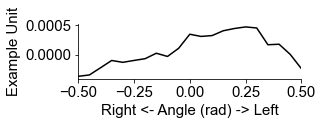

In [8]:
fig, ex_ax = plt.subplots(figsize=example_sz)
ex_ax.set_xlim([-0.5, 0.5])
ex_ax.plot(np.linspace(-0.5, 0.5, 21), pes_cuep_vabinned[utils.sort_by_max_loc(pes_cuep_vabinned),:][EX_UNIT_VA_IDX,:].T, color ='k')
ex_ax.set_xlabel('Right <- Angle (rad) -> Left');
ex_ax.set_ylabel('Example Unit');

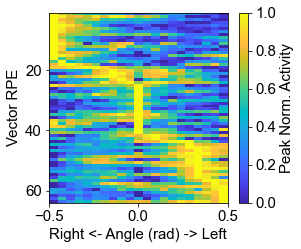

In [9]:
fig, ax_va = plt.subplots(figsize = heatmap_sz)
im = ax_va.imshow(utils.norm_within_feat(pes_cuep_vabinned)[utils.sort_by_max_loc(pes_cuep_vabinned),:],
                    aspect = 'auto', extent = [-0.5, 0.5, 64, 1], cmap = utils.parula_map, interpolation = 'none')
ax_va.set_yticks([20, 40, 60]) #  32,
ax_va.set_yticklabels(['20', '40', '60'])
ax_va.spines['right'].set_visible(True)
ax_va.spines['top'].set_visible(True)
ax_va.set_xlabel('Right <- Angle (rad) -> Left');
ax_va.set_ylabel('Vector RPE');
cbar = plt.colorbar(im)
cbar.set_label('Peak Norm. Activity')


## Figure 3B: Position Plot



In [10]:
# *SLOPE* sorted position from matlab withonly position sensitive units
# from matlab script: timelock_to_pos.m
norm_pes_pos = loadmat(load_prefix + 'sorted_norm_pos_pes.mat')['norm_pes']
ypos_pes_pos = np.squeeze(loadmat(load_prefix + 'sorted_norm_pos_pes.mat')['num_steps_xticks'])
order = np.squeeze(loadmat(load_prefix + 'sorted_norm_pos_pes.mat')['order']) - 1
slopevec = np.squeeze(loadmat(load_prefix + 'sorted_norm_pos_pes.mat')['slopvec'])


POS_SEN_UNIT_START = 25
EX_UNIT_POS_IDX = 34

peak_order = utils.sort_by_max_loc(utils.norm_within_feat(np.nanmean(pes_cuep,-1).T))
norm_pes = utils.norm_within_feat(np.nanmean(pes_cuep,-1).T)
psorted_norm_pes_pos = norm_pes[peak_order,:]

order_possenonly = [value for value in order if value in peak_order[POS_SEN_UNIT_START:]]
norm_pes_pos_possenonly = norm_pes_pos[order_possenonly,:]

pes_pos = np.nanmean(pes_cuep[117:,:,:],-1).T;
pes_pos_possenonly = pes_pos[order_possenonly,:]



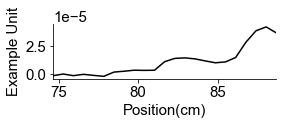

In [11]:
fig, ex_ax = plt.subplots(figsize=example_sz)
ex_ax.plot(ypos_pes_pos, pes_pos_possenonly[EX_UNIT_POS_IDX,:].T, color = 'k')
ex_ax.set_xlim([ypos_pes_pos[0], ypos_pes_pos[-1]]);
ex_ax.set_xlabel('Position(cm)');
ex_ax.set_ylabel('Example Unit');

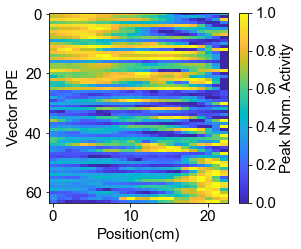

In [12]:
fig, ax_pos = plt.subplots(figsize=heatmap_sz)
im = ax_pos.imshow(norm_pes_pos[order,:], cmap = utils.parula_map,
                    aspect = 'auto',interpolation = 'none')

ax_pos.spines['right'].set_visible(True)
ax_pos.spines['top'].set_visible(True)
ax_pos.set_xlabel('Position(cm)');
ax_pos.set_ylabel('Vector RPE');
cbar = plt.colorbar(im)
cbar.set_label('Peak Norm. Activity')

## Figure 3C: Cue Response Plot

In [13]:
leftCue_ = [trialcue[0][0] -2 for trialcue in cueOnset_]
rightCue_ = [trialcue[1][0] -2 for trialcue in cueOnset_]

get_timelocked_cues = lambda pes_, cueLocs: np.dstack([utils.timelock_to_cue(pes_, cueLocs, pes_i) for pes_i in np.arange(64)])

pes_lcue = get_timelocked_cues(pes_,leftCue_)
pes_rcue = get_timelocked_cues(pes_,rightCue_)

In [14]:
vmin = loadmat(load_prefix + 'sorted_pes_lcuercue2.mat')['imedg1']
vmax = loadmat(load_prefix + 'sorted_pes_lcuercue2.mat')['imedg2']
norm_pes_lcue = loadmat(load_prefix + 'sorted_pes_lcuercue2.mat')['mrContra']
norm_pes_rcue = loadmat(load_prefix + 'sorted_pes_lcuercue2.mat')['mrIpsi']
sort_order =  np.squeeze(loadmat(load_prefix + 'sorted_pes_lcuercue2.mat')['order']) - 1
# UNIT 40 is the delimitor between LEFT and RIGHT sensitive cues
LR_DELIM = 40
EX_UNIT_LEFT_IDX = 9
EX_UNIT_RIGHT_IDX = 43

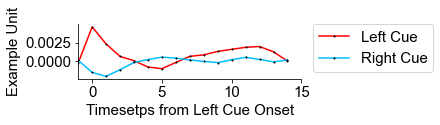

In [15]:
fig, ex_ax = plt.subplots(figsize = example_sz)

ex_ax.plot(np.arange(-1, 15), np.nanmean(pes_lcue,0)[4:-10, sort_order[EX_UNIT_LEFT_IDX]], **marker_plots, label = 'Left Cue', color = left_col)
ex_ax.plot(np.arange(-1, 15), np.nanmean(pes_rcue,0)[4:-10, sort_order[EX_UNIT_LEFT_IDX]], **marker_plots, label = 'Right Cue', color = right_col)
ex_ax.set_xlim(-1, 15)
ex_ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ex_ax.set_xlabel('Timesetps from Left Cue Onset');
ex_ax.set_ylabel('Example Unit');

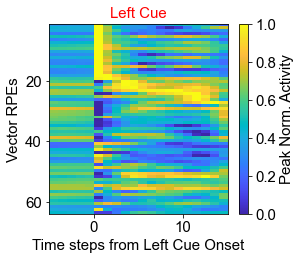

In [16]:
fig, left_ax = plt.subplots(figsize = heatmap_sz)
im = left_ax.imshow(norm_pes_lcue[sort_order,:-10], aspect = 'auto', extent = [-5,15,64,1],
                    cmap = utils.parula_map , interpolation = 'none') # ,vmin = vmin, vmax = vmax)
left_ax.set_title('Left Cue', color = left_col, fontsize = 15)

left_ax.set_yticks([20, 40, 60]) # EX_UNIT_LEFT_IDX,
left_ax.set_yticklabels([ '20', '40', '60'])
left_ax.set_xticks([0,10])

left_ax.spines['right'].set_visible(True)
left_ax.spines['top'].set_visible(True)

left_ax.set_xlabel('Time steps from Left Cue Onset')
left_ax.set_ylabel('Vector RPEs')
cbar = plt.colorbar(im)
cbar.set_label('Peak Norm. Activity')

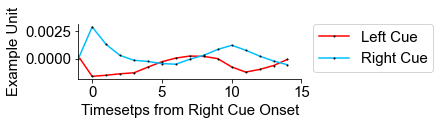

In [17]:
fig, ex_ax = plt.subplots(figsize = example_sz)
ex_ax.plot(np.arange(-1, 15), np.nanmean(pes_lcue,0)[4:-10, sort_order[EX_UNIT_RIGHT_IDX]], **marker_plots, label = 'Left Cue', color = left_col)
ex_ax.plot(np.arange(-1, 15), np.nanmean(pes_rcue,0)[4:-10, sort_order[EX_UNIT_RIGHT_IDX]], **marker_plots, label = 'Right Cue', color = right_col)

ex_ax.set_xlim(-1, 15)
ex_ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ex_ax.set_xlabel('Timesetps from Right Cue Onset');
ex_ax.set_ylabel('Example Unit');

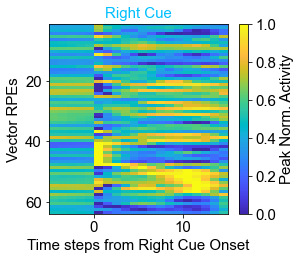

In [18]:
fig, right_ax = plt.subplots(figsize = heatmap_sz)
im = right_ax.imshow(norm_pes_rcue[sort_order,:-10], aspect = 'auto', extent = [-5,15,64,1],
                        cmap = utils.parula_map, interpolation = 'none') # , vmin = vmin, vmax = vmax)
right_ax.set_title('Right Cue', color = right_col, fontsize = 15)
right_ax.spines['right'].set_visible(True)
right_ax.spines['top'].set_visible(True)
right_ax.set_yticks([20, 40, 60]) 
right_ax.set_yticklabels(['20', '40', '60'])
right_ax.set_xticks([0, 10])

right_ax.set_xlabel('Time steps from Right Cue Onset');
right_ax.set_ylabel('Vector RPEs');
cbar = plt.colorbar(im)
cbar.set_label('Peak Norm. Activity')

## Figure 3D: VA neural plot

In [19]:
# all neural data uses matlab code: neural_behavior.m
va_hm = loadmat('./data/neural_behaviors.mat')['va_heatmap']
va_ex = loadmat('./data/neural_behaviors.mat')['va_ex'][0]
va_ex_se = loadmat('./data/neural_behaviors.mat')['va_ex_se'][0]


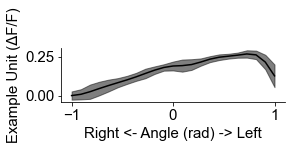

In [20]:
fig, ex_ax = plt.subplots(figsize=example_sz)
ex_ax.plot(np.linspace(-1,1, 23), va_ex, color ='k')
ex_ax.fill_between(np.linspace(-1,1, 23), va_ex - va_ex_se, va_ex + va_ex_se, color =  'k', alpha = 0.5)

ex_ax.set_xlabel('Right <- Angle (rad) -> Left');
ex_ax.set_ylabel('Example Unit (ΔF/F)');

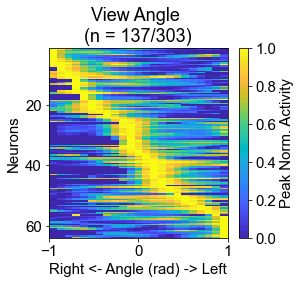

In [21]:
fig, ax_va = plt.subplots(figsize = heatmap_sz)
va_hm[np.isnan(va_hm)] = 0
im = ax_va.imshow(va_hm, aspect = 'auto', extent = [-1, 1, 64, 1], cmap = utils.parula_map, interpolation = 'none')
ax_va.spines['right'].set_visible(True)
ax_va.spines['top'].set_visible(True)
ax_va.set_xlabel('Right <- Angle (rad) -> Left');
ax_va.set_ylabel('Neurons');
ax_va.set_title('View Angle \n(n = 137/303)')
cbar = plt.colorbar(im)
cbar.set_label('Peak Norm. Activity')

## Figure 3E: Position neural plot

In [22]:
# all neural data uses matlab code: neural_behavior.m
pos_hm = loadmat('./data/neural_behaviors.mat')['pos_heatmap']
pos_ex = loadmat('./data/neural_behaviors.mat')['pos_ex'][0]
pos_ex_se = loadmat('./data/neural_behaviors.mat')['pos_ex_se'][0]


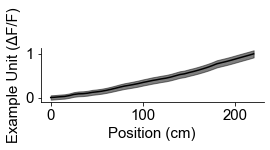

In [23]:
fig, ex_ax = plt.subplots(figsize=example_sz)
ex_ax.plot(np.linspace(0,220, 45), pos_ex, color ='k')
ex_ax.fill_between(np.linspace(0,220, 45), pos_ex - pos_ex_se, pos_ex + pos_ex_se, color =  'k', alpha = 0.5)

ex_ax.set_xlabel('Position (cm)');
ex_ax.set_ylabel('Example Unit (ΔF/F)');

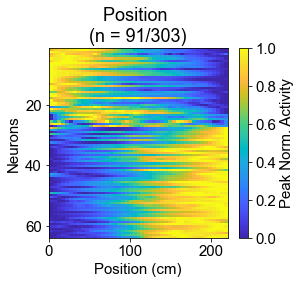

In [24]:
fig, ax_va = plt.subplots(figsize = heatmap_sz)
im = ax_va.imshow(pos_hm, aspect = 'auto', extent = [0, 220, 64, 1], cmap = utils.parula_map, interpolation = 'none')
ax_va.spines['right'].set_visible(True)
ax_va.spines['top'].set_visible(True)
ax_va.set_xlabel('Position (cm)');
ax_va.set_ylabel('Neurons');
ax_va.set_title('Position \n(n = 91/303)')
cbar = plt.colorbar(im)
cbar.set_label('Peak Norm. Activity')